### Part I: Markov Chain

The goal of this section will be to implement a Markov Chain class where for a given set of states, and transition matrix $p$, we create a Markov Chain.
For the purpose of this project, we will make the simplifying assumption that the states are listed as integers (with the future assumption that the integer represent winning monetary amounts)

In [416]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [431]:
class markov_chain:
    '''
    Implementation of a Markov Chain

    Inputs:
        - p: a transition matrix (n*n dim list)
        - states: all states in the state space (list)
        - initial_dist: the initial distribution

    Methods:
        - display_graph: plots a transition graph of the Markov Chain
    
    '''

    def __init__(self, p, states, initial_dist = -1):
        '''
        Initializing the Markov Chain
        '''
        #First, we convert the input into an array representing the transition matrix
        try: 
            self.transition_matrix = np.array(p)

        except ValueError as err:
            #ValueError is thrown here if not all lists within the lists have the same dimension
            message = f'\nMarkov Chain must be a square Matrix!'
            raise Exception(message) from err

        #Ensuring that the number of the number of rows = the number of cols - ensuring the input transition matrix is square
        assert self.transition_matrix.shape[0] == self.transition_matrix.shape[1], f'\nMarkov Chain must be a square Matrix!'

        #storing the total number of states. Will be useful later
        self.num_states = len(self.transition_matrix)

        #Avoiding the case of when the num_state is 0! This breaks a lot of things
        assert self.num_states > 0, f'\nMarkov Chain must have at least one state!'

        #Throwing an error when the transition matrix does not satisfy the law of probability
        for i in range(self.num_states):
            msg = f'\nAll rows of Markov Chain must sum to 1! \nRow {i+1} does not sum to 1.'
            assert np.sum(self.transition_matrix[i]) == 1, msg

        #storing the states
        self.states = states


        #Creating the transition graph using a directed weighted graph from the networkx library!
        #The plotting was admittedly finnicky...
        G = nx.DiGraph(directed = True)
        #adding the states as nodes first
        G.add_nodes_from(list(states))
        edges = []

        #for each entry of the transition matrix
        for i in range(self.num_states):
            for j in range(self.num_states):
                #this value is the transition probability from state i to j
                #this will be used as the weight for each edge    
                w = self.transition_matrix[i][j]
                #adding to the initialized empty list of edges
                edges.append((states[i],states[j],w ))
                #we only add those edges that have weight greater than 0.
                # in other words, we omit including transitions that have 0 probability
                if w!=0:
                    G.add_edge(states[i],states[j],weight = w, label = w)

        #storing the graph
        self.graph = G


        #if the initial distribution is not provided, we assume uniform
        if initial_dist == -1:
            self.initial_dist = [1/self.num_states for i in range(self.num_states)]

        else:
            #creating certain conditions to ensure things don't break!
            #first, we ensure that the initial distribution indeed has a value for each state
            #secondly, we ensure that the sum of the probability values of the init dist indeed add up 1
            assert len(initial_dist) == self.num_states, f'\nA probability value must be assigned to each state - no more, no less!'
            assert sum(initial_dist) == 1, f'\nSum of initial probability distribution must equal 1!'
            self.initial_dist = initial_dist


        #a helper function is created here to collect the absorbing states
        def absorbing_states():
            #initializing to an empty list
            absorbing_states = []
            #iterating through each state
            for i in range(self.num_states):
                #since we have already ensured that each row sums to 1, if mat[i][i]=1,
                #then this implies all mat[i][j] =0 for i!= j
                #essentially, we check only the diagonal entries
                if self.transition_matrix[i][i] == 1:
                    #adding to the list of absorbing states
                    absorbing_states.append(self.states[i])
            #returning the filled list
            return absorbing_states
        

        #calling the function and storing the absorbing states
        self.absorbing_states = absorbing_states()


    #plotting the graph. Could use work!
    def display_graph(self):

        pos = nx.spring_layout(self.graph)
        options = {
            'node_color': 'green',
            'node_size': 1000,
            'width': 1
        }

        #we ensure that the edges are curved, so edges in opposite directions of the same nodes both show
        nx.draw(self.graph, pos, **options, with_labels=True, connectionstyle='arc3, rad = 0.2')
        #we want the labels to be the edges
        weight_labels = nx.get_edge_attributes(self.graph,'weight')
        #nx.draw_networkx_edge_labels(self.graph,pos, edge_labels = weight_labels)
        #we were not able to print the labels on the graph itself, so we will print it above for now!
        print(weight_labels)
        plt.show()
        
        return

### Part II: Markov Process

In this section, we will focus on implementing a *Markov Process*. This will include a simulating mechanism, and embedded analysis to make certain inferences.

In [418]:
#We now create a class called Markov Process to generate everything we need there.
#Note, we will delete cells with previous exploration

In [489]:
class markov_process:
    '''
    An implementation of the markov_process 

    Inputs:
        - a markov chain (using the class defined above)

    Methods:
        - i_of_state: prints the index of a state in the list of all states
        - sim_one_iter: running one instance of the markov chain
        - run_n_iters: running n instances of the markov chain
        - plot_history: plotting the history of states over the states
        - plot_state_dist: plotting a frequency bar plot of the number of times each state was visited 
        - check_freq: a helper function to see how many times a state was visited in the markov process
    '''

    def __init__ (self, mc):
        '''
        Initializing the markov_process
        '''
        #storing the markov chain for any things not explictly extracted
        self.mc = mc

        #The transition matrix, state space, initial distribution are called
        #enough to make it simplier to inheret them once into this class
        self.transition_matrix = mc.transition_matrix
        self.states = mc.states
        self.initial_dist = mc.initial_dist

        #We start with no current state
        #If the user tries to call the current_state, we would like to show them this message
        self.current_state = 'No current state - the Markov Process has not begun!'

        #values that will be updated throughout the markov process
        self.time = 0
        self.states_hist = []

    
    def i_of_state(self, state):
        '''
        Collecting the index of a given state in the list of all states

        Inputs:
            - the desired state (int)
        
        Ouputs:
            - the index of said desired state (int)
        '''
        i = self.states.index(state)
        return i


    def sim_one_iter(self, msgs = True):
        '''
        Simulating one iteration of the Markov Process
        Updates the time, path, current state

        Inputs:
            - msgs: displaying information (bool)

        Outputs:
            - None
        '''

        #if there has not been a simulation before, we would use the initial distribution
        #opposed to the transition matrix to generate the next state
        if type(self.current_state) == str:

            #the state is decided based on a weighted choice between the states using the 
            #initial distribution
            state = np.random.choice(self.states, 1, p = self.initial_dist)

            #updating the current state
            self.current_state = state[0]
            #adding the generated state to the list containing the path
            self.states_hist.append(self.current_state)

            #if the user wants to see the result
            if msgs:
                print(f'At time period {self.time}, the Markov Process is in state: {self.current_state}')
        
        #if there has already been a simulation before, we use the transition matrix
        else:

            #collecting the index of the state
            i = self.i_of_state(self.current_state)

            #accessing the transition probabilities from the given state
            p = self.transition_matrix[i]
            
            #state is now decided based on the previously collected vector
            state = np.random.choice(self.states, 1, p = p)

            #updating the current state, path, and time period
            self.current_state = state[0]
            self.states_hist.append(self.current_state)
            self.time+=1

            #if the user wants to see the result
            if msgs:
                print(f'At time period {self.time}, the Markov Process is in state: {self.current_state}')

    
    def run_n_iters(self, n, msgs = True):
        '''
        Simulating n iterations of the Markov Process
        Ends at n or if an absorbing state is reached, whichever comes first

        Inputs:
            - n: desired number of iterations (int)
            - msgs: displaying information (bool)
        '''

        #If the current state is not an absorbing state. If it is, we would not like to run any iterations
        if (self.current_state not in self.mc.absorbing_states):
            
            #running n iterations...
            for i in range(n):
                
                #...however, if an absorbing state is reached, we end
                self.sim_one_iter(msgs = False)
                
                if self.current_state in self.mc.absorbing_states:
                    break
           
            #printing result if user would like
            if msgs:
                print(f'At stopping time period {self.time}, the history of states are {self.states_hist}')
        
        #if we are an absorbing state
        else:
            print(f'At an absorbing state!')
    

    def plot_hist(self):
        '''
        Plots a history of the states over the time period simulated until
        '''
        
        ax = plt.axes()
        #Marking the states as squares, and creating dotted lines between
        plt.plot(np.arange(self.time+1),self.states_hist, label = 'States', marker = 's', linestyle = '--', c = 'g')

        #only want to create a grid if there are more than 2 states
        if self.mc.num_states > 2:
           ax.grid(color="gray", which="both", linestyle=':', linewidth=0.7)

        #labels
        ax.set_yticks(ticks = self.states)
        ax.autoscale()
        ax.set_ylabel('State')
        ax.set_xlabel('Time period')
        ax.set_title(f'Result of Markov Process over {self.time} iterations')

        plt.show()


    def plot_state_dist(self):
        '''
        Plotting a barplot with frequencies of each the number of visits at each state
        '''
        ax = plt.axes()
        dist = self.check_freq()
        ax.bar(self.states, dist)
        #labels
        ax.set_ylabel('Frequency')
        ax.set_xlabel('State')
        ax.set_title(f'The number of times of each state has been visited in {self.time} periods')
        ax.set_xticks(self.states)


    def check_freq(self):
        '''
        A helper function to check the frequency for the graph above
        '''
        dist = []
        for state in self.states:
            freq = self.states_hist.count(state)
            dist.append(freq)

        return dist
        

### Part III: Markov Reward

Because we will spend a significant portion of the rest of this project focusing on the Gambler's Ruin, we will code a function to generate a gamblers ruin Markov Chain first:

In [420]:
def gamblers_ruin_mc(n,p= 0.5, start = 1):
    '''
    A function to initialize a markov chain using the Gambler's Ruin principle

    Inputs:
        - n: the number of states. Generates 0,1,...,n as all states
        - p: the probability of moving forward, default set to 1/2
        - start: what the player starts with, default set to $1
    '''

    #creating the transition matrix
    mat = []
    #adding the first row, which will be a 1 followed by n-1 0s
    mat.append([1]+((n-1)*[0]))

    #adding the 2nd through n-1th rows with the corresponding index
    #the chance of setback is 1-p while the chance of advancing is p
    for i in range (1,n-1):

        #creating a vector to be added to the matrix
        #initializing to all 0s initially
        m = n*[0]
        #changing the i-1 and i+1 entries
        m[i-1] = 1-p
        m[i+1] = p

        #adding to the matrix
        mat.append(m)

    #appending the last row, which will be filled with n-1 0s followed by a 1
    mat.append(((n-1)*[0])+[1])

    #Since we determine the starting value with gamblers ruin, we initalize a
    # determined initial distribution - always resorting to one value
    initial_dist = n*[0]
    initial_dist[start] = 1

    #the states are 0 through n-1
    states = [i for i in range(n)]

    #initializing and returning the Markov Chain
    mc = markov_chain(mat,states, initial_dist)
    
    return mc

As mentioned earlier, we made the assumption that each state is represented by an integer denoting a monetary value, as in the case of the Gambler's Ruin. We now define a reward function, based on the theory of decreasing marginal utility

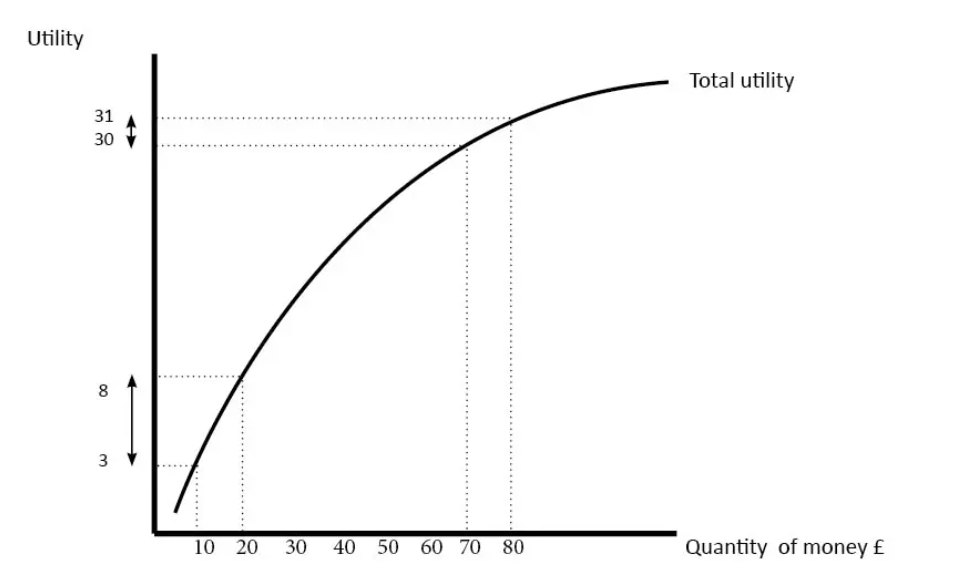

Here, we can see that the total utility decreases with time. This is called the expected utility theory of economics. We will use an implementation based on this theory to evaluate our reward (used interchangeably with utility here).
For the purposes of this project, we will set the total utility function to be $$ y=a* \sqrt{x}$$

Where $a$ is a constant coefficient. Note that, with this defintion, $ y = x $ at $\sqrt{a}$ 

## Analysis

Before implementing a reward feature, it is useful to see how the program shapes up so far - what it is capable of!

First, let us explore the consequences of different incorrect entries:

In [442]:
p = [[1,1], [1,1]]
states = [1,2]
mc_fail = markov_chain(p,states)

AssertionError: 
All rows of Markov Chain must sum to 1! 
Row 1 does not sum to 1.

<br>

**As we can see, by having row one not sum up to 1, we have created an error, as desired!**

<br>

In [478]:
p = [[0.5,0.5], [1]]
states = [1,2]
mc_fail = markov_chain(p,states)

Exception: 
Markov Chain must be a square Matrix!

<br>

**Similarly, when we inputted a matrix with incorrected dimensions, we have created an error, citing that the matrix must be square!**


<br>

In [447]:
p = [[0.5,0.5], [0.5,0.5]]
states = [1,2]
initial_dist = [0.5,0.3]
mc_fail = markov_chain(p,states, initial_dist)

AssertionError: 
Sum of initial probability distribution must equal 1!

<br>

**And that is what happens when the initial distribtution is not set to 1**

<br>

In [448]:
p = [[0.5,0.5], [0.5,0.5]]
states = [1,2]
initial_dist = [0.5,0.3, 0.2]
mc_fail = markov_chain(p,states, initial_dist)

AssertionError: 
A probability value must be assigned to each state - no more, no less!

<br>

**We can see that the we are thrown an error when there are more initial distribution entries than there are states**

<br>

Let us now create a Gambler's Ruin Problem and play around with things:

In [433]:
#creating an instance of a Markov Chain using the Gambler's ruin function
#initializing to have 20 states, with 70% chance of success, and starting at 4
mc = gamblers_ruin_mc(20,p = 0.7, start = 4)

Let's explore different methods and variables that exist within the Markov Chain class:

In [455]:
mc.states

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [456]:
mc.num_states

20

In [457]:
mc.absorbing_states

[0, 19]

In [458]:
mc.initial_dist

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

{(0, 0): 1.0, (1, 0): 0.30000000000000004, (1, 2): 0.7, (2, 1): 0.30000000000000004, (2, 3): 0.7, (3, 2): 0.30000000000000004, (3, 4): 0.7, (4, 3): 0.30000000000000004, (4, 5): 0.7, (5, 4): 0.30000000000000004, (5, 6): 0.7, (6, 5): 0.30000000000000004, (6, 7): 0.7, (7, 6): 0.30000000000000004, (7, 8): 0.7, (8, 7): 0.30000000000000004, (8, 9): 0.7, (9, 8): 0.30000000000000004, (9, 10): 0.7, (10, 9): 0.30000000000000004, (10, 11): 0.7, (11, 10): 0.30000000000000004, (11, 12): 0.7, (12, 11): 0.30000000000000004, (12, 13): 0.7, (13, 12): 0.30000000000000004, (13, 14): 0.7, (14, 13): 0.30000000000000004, (14, 15): 0.7, (15, 14): 0.30000000000000004, (15, 16): 0.7, (16, 15): 0.30000000000000004, (16, 17): 0.7, (17, 16): 0.30000000000000004, (17, 18): 0.7, (18, 17): 0.30000000000000004, (18, 19): 0.7, (19, 19): 1.0}


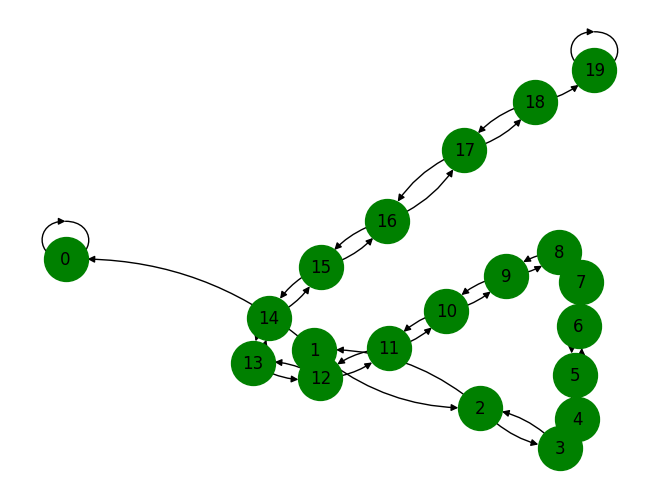

In [459]:
mc.display_graph()

As we can see, everything is as desired! We yielded the right number of states, the right arrangement of the state values, the desired initial distribution, set to always be 4, and a correct though admittedly chaotic graph!

Now, let us initialize the Markov Process

In [490]:
mp = markov_process(mc)

In [491]:
mp.states

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [492]:
mp.current_state

'No current state - the Markov Process has not begun!'

In [493]:
mc.absorbing_states

[0, 19]

We see that when we called the current state variable, it told us that there is no current state, as desired, as we have yet to start the process! We can also see that the correct abosrbing states were recognized.

Let us now simulate two iterations individually, one to start the process and one more

In [494]:
mp.sim_one_iter()

At time period 0, the Markov Process is in state: 4


In [495]:
mp.sim_one_iter()

At time period 1, the Markov Process is in state: 5


With a 70% chance of success, our first run led to us winning a dollar! Let us now simulate 10 to see how we fare:

In [496]:
mp.run_n_iters(10)

At stopping time period 11, the history of states are [4, 5, 4, 5, 6, 5, 4, 5, 6, 7, 8, 9]


With the skewed chance of winning, we have now made our way to $9! As we ran one time period, and then 10 more, we are now stopped at time period 11, as correctly stated!

Let us now run 50 more to see if we can win!

In [497]:
mp.run_n_iters(50)

At stopping time period 35, the history of states are [4, 5, 4, 5, 6, 5, 4, 5, 6, 7, 8, 9, 10, 11, 12, 11, 12, 13, 12, 11, 12, 13, 12, 13, 12, 11, 12, 13, 14, 15, 16, 17, 18, 17, 18, 19]


We have stopped at time period 35! As we can see with the history of states, this is due to us hitting state 19 - which means we have successfully won!

Let us take a look at how these results graphically

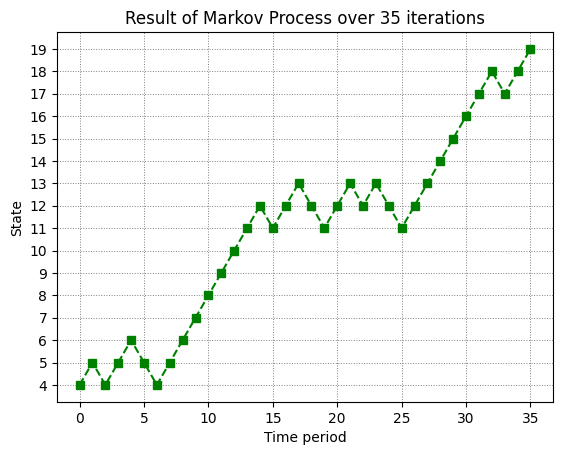

In [498]:
mp.plot_hist()

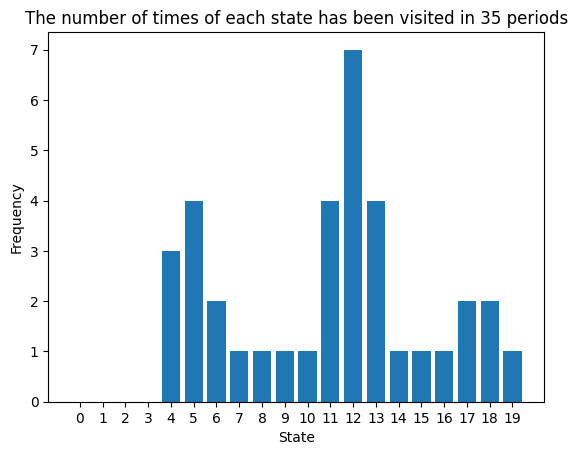

In [499]:
mp.plot_state_dist()

Luck was in our favor! There was a bumpy period in between periods 14 and 25 where we actually net lost a dollar, but overall results are strong. We can see from the second graph that we visited state 12 most frequently.
More importantly, our graphs do what they are expected to do! 

## Future work

Unfortunately, I did not have time to further expand on this work. As outline in the first section of this, my goal will be to expand by first implementing a reward system behind every stage in order to understand overall progression of utility. I will also implement a "trial" system where for a given configuration, I run numerous trials to get a better idea of the distribution of the winning time iterations over a larger sample. The agency to be implemented can take many forms. To keep things simple, I decided I would start with the simple option of being able to stop playing at any time interval. While this might seem trivial for the Gambler's Ruin, keep in mind, our goal is to maximize utility, which is not necessarily the same as money! Utility will take on a discount factor and a normalizing for amount earnt (allowing for our concave utility graph). Excited to continue expanding on what I have here!